In [1]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Confidence Interval Tests (Review)
Let's start the lecture with review about confidence interval tests and some clarifications about using confidence interval.

## 95% Confidence Interval
Recall we used confidence interval to create an interval of **estimates of a parameter** in the population that we are interested in. 
1. It's based on random sampling
2. 95% is called the **confidence level**
    * The % could be anything between 0 to 100
    * The higher %, the wider interval we will obtain. On the same time, wider interval means less accurate.
3. The **confidence is in the process** that generated the interval
    * Meaning: If we go from population to sample to resample, the entire process will generate a **good interval** about 95% of the time.
    * Note: **"Entire process" includes going back to population and taking more sample**, which in real life case is often not possible since we don't have access to the population

## Demo
In the last few lectures, we have been using real datasets. This time, we will use a made-up dataset. Below we have the functions `bootstrap_mean` and `bootstrap_ci_mean` from **Lecture 24 - Confidence Interval**

In [2]:
def bootstrap_mean(sample_from_population, label, repetitions):
    """ Returns a list of resampled mean.
    sample_from_population: An original sample taken from the population
    label: the label within the sample table that we want to bootstrap
    repetitions: the number of repetition
    
    """
    resampled_mean = []
    for i in np.arange(repetitions):
        resample = sample_from_population.sample()
        # Below we use np.mean
        resampled_mean.append(np.mean(resample.column(label)))
    return resampled_mean

In [3]:
def bootstrap_ci_mean(sample_from_population, label, repetitions):
    # Use the `bootstrap_mean` method and store the values in the list "resampled_means"
    resampled_means = bootstrap_mean(sample_from_population, label, repetitions)
    
    # Compute the left 2.5% and right 2.5% cutoffs
    interval_95 = make_array(
        percentile(2.5, resampled_means),
        percentile(97.5, resampled_means)
    )
    
    #Construct the histogram and the 95% Confidence Interval horizontal line
    Table().with_column('Resampled mean', resampled_means).hist('Resampled mean')
    plt.plot(interval_95, [0, 0], color = 'gold', lw = 8)
    print('Approximate 95% Bootstrap Confidence Interval for the Population Mean:')
    print(np.round(interval_95, 3))

And below we have a fake dataset called **`flips`**, which is a dataset of results of flipping an **unfair** coin. `1` represents heads, `0` represents tails. 

In [4]:
# Heads is 1, Tails is 0
flips = Table.read_table('unfair_flips.csv')
flips.show(3)

Heads
1
0
0


This problem is based on the Google interview question, 

"We think we have an unfair coin. We think the coin has either 0.6 or 0.9 chances to get head. How do we decide between the 2?"

What they're looking for is not us making hypothesis test on either one. If the coin is biased, either 0.6 or 0.9 seem equally likely to be good as the `null` hypothesis. Instead, they're looking for us to estimate a range of values the coin is possibly biased towards.

Let's group the `flips` by the flipping result,

In [5]:
# Group the flip result!
flips.group('Heads')

Heads,count
0,42
1,133


### How unfair can this coin be?
Before proceeding to the lecture, we haven't covered the idea of using the `mean` as taking the proportions of some value.

### Aside: Taking the Mean for Computing the Proportion of a Value
Suppose we have an array of `0`s and `1`s, 

In [6]:
make_array(0, 0, 1, 1)

array([0, 0, 1, 1])

If we take the mean of an array containing only zeroes and ones, it will give us the proportion of ones.

In [7]:
np.mean(make_array(0, 0, 1, 1))

0.5

How did that work?

1. We sum all the values. We obtain `2`.
2. Divide it by the total element in the array, which is `4`
3. We obtain 2/4, or 0.5.

If we remove a `1`, we'll obtain `1/3`.

In [8]:
np.mean(make_array(0, 0, 1))

0.3333333333333333

Conveniently enough, this way if a data only contains `0` and `1`, we can compute the `mean` to obtain proportion.

Now back to our `flips` dataset, we can take the `mean` of the data,

In [9]:
np.mean(flips.column('Heads'))

0.76

As we can see above, there're about 76% heads in the `flips` dataset. 

As usual, we can use the `boostrap_ci_mean` function on the `flips` data,

Approximate 95% Bootstrap Confidence Interval for the Population Mean:
[0.697 0.823]


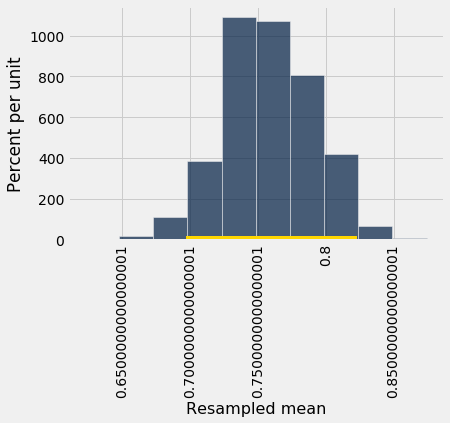

In [10]:
bootstrap_ci_mean(flips, 'Heads', 5000)

From the result above, we can infer that the coin is probably biased towards the heads with a chance of between 0.7 to 0.9 of obtaining heads.

Recall from past lecture, we looked at a confidence interval and see if the value 0 is within the interval and how that ties back to our `P-value` and A/B Testing hypothesis test. 

In this case, turns out we can use the confidence interval to conduct a hypothesis test. If the `null` hypothesis is that the coin is fair, then the chance of getting heads should be 0.5. Thus we can just check whether 0.5 is within the confidence interval. If it doesn't contain 0.5, then we can infer that the coin is not fair. 

Suppose we conduct the normal steps of hypothesis test. 
1. We set up `null` and `alternative` hypotheses
    * `null`: the coin is far
    * `alternative`: the coin is not fair
2. Choose `test statistic`: the proportion of heads in 175 flips
3. Do simulation of 175 flips under the null hypothesis (pretend that the coin is fair)
4. Compute the proportion of heads
5. Repeat step 3 and 4 multiple times and collect the `test statistic`s
6. Construct a distribution of the `test statistic`, which is the distribution of the proportion of heads
    * The distribution should look like a bell curve centered at 0.5 since the simulation is conducted under the null hypothesis
    
Recall that when we conduct the bootstrap, we pretend that the sample is the population. Notice that in our `flips` sample,

In [11]:
# Group the flip result!
flips.group('Heads')

Heads,count
0,42
1,133


There're 133 heads and 42 tails. Every time we resample from the `flips` sample, it's 3 times more likely to obtain `heads` compared to obtaining `tails`. 

When we do the normal hypothesis test, our distribution is centered at 0.5 because we did the test assuming the null hypothesis is true (that the coin is fair, that the coin has 0.5 chance of obtaining heads).

In the boostrap case, the distribution is going to be centered at the sample `mean`, which is,

In [12]:
np.mean(flips.column('Heads'))

0.76

However, the variability of the distribution is the same as if we did the normal hypothesis test because for both cases, the sample size is the same: 175. This way, in both cases we will have the same bell curve shape distribution.

## Using a CI for Testing
We can use a hypothesis test to conduct the hypothesis test.

1. `Null hypothesis`: the population `mean` is some value `x`
2. `Alternative`: the population `mean` is not `x`
3. When we choose the cutoff for the `P-value`, we construct a confidence interval of (100-p)% for the population average. 
    * If we say that our `P-value` cutoff is 5%, then we want a 95% confidence interval.
4. Check if `x` is within the interval. If not, then reject the null

# Average
All this time, we have been studying inference, which is taking a sample and drawing conclusion about the population. Now we are going to study **prediction**. Given some data or sample, can we make some prediction? To do that, we need building blocks, in which one of them is **average**.

We calculate the average of some numbers by taking the sum of the numbers and dividing it with the amount of numbers.
So if `Data : 2, 3, 3, 9`, then `Average = (2 + 3 + 3 + 9) / 4 = 4.25`.

1. The `average` is not necessarily a value in the collection. 
    * Recall when we studied percentile, percentiles refer to a value in a collection. For example, the 49th percentile is a number from our data. In this case, the `average` is not necessarily a value in the data.
    

2. Even if the data are integers, the `average` is not necessarily an integer. 
3. The `average` is somewhere between the `min` and `max` of the data, but not necessarily halfway in between
4. The `average` has the same units as the data (e.g. Celsius, km, grams, eggs)

We can think of the `average` as the **smoothing operator**. For example, with the data that we have, `9` is a spike that is higher than other numbers. The `average` "lowers" the 9, but it is going to be higher than the small values (`2`, `3`). This is convenient for temperature readings. If we take temperature readings, sometimes the thermometer would spike up or down. If we take the average of, let's say, 3 readings, we can obtain the average reading that is more smooth. This way, we can see the temperature readings over the course of the day more easily. 

## Discussion Question
Suppose we have the following data on NBA players' heights. 
<img src = 'NBA.jpg' width = 700\>

From the data above, which one is greater: `mean` or `median`?

#### Answer:
If our data were symmetrical, the `mean` and `median` would be roughly in the same position. On the other hand, the data above has a tail on the left side, which affects the `mean` because this means we have more extreme low values that drags down the `mean`. Thus, the `median` is more likely to be grater.

## Properties of the Mean
1. We can think of the `mean` as the balance point of the histogram.
2. `mean` is not the halfway point of the data. That's `median`
3. If the distribution is symmetric about a point, then that point is both `mean` and `median`
4. If the distribution is symmetric about a point, then that point is both the average and the median
5. If the histogram is skewed (the tail is longer in one direction than the other), then the `mean`  is pulled away from the median to the direction of the tail

## Demo: Means
Let's say we have the following values. These values are the same data as discussed before. The `mean` is not affected by the order in which the numbers appear.

In [13]:
values = [3, 2, 9, 3]

The `mean` can be calculated in many ways:

In [14]:
np.average(values)

4.25

In [15]:
np.mean(values)

4.25

In [16]:
sum(values) / len(values)

4.25

Another way to think of the `mean` is as a **weighted average of the number of times each element appear**. For example, in `values` we have the following:
* 3 appears twice
* 2 and 9 appear once

Thus in this case, we can take the proportion of times each number appear, multiply it with the number of times it appear, and sum all of them. 

In [17]:
(2/4) * 3 + (1/4) * 2 + (1/4) * 9

4.25

# Standard Deviation
Suppose we have 2 distributions (e.g. one is wider (more spread out), one is narrow) that are both perfectly symmetrical (the `mean` and `median` are the same), and they are centered at the same point. In this case, we can't use `median` nor `mean` to distinguish between the 2 distributions. We need to use a different measurement. In this case, we use **Standard Deviation**. The **standard deviation** measures the variability of a value in a distribution (e.g. how wide the values can be).

## Defining Variability

1. Method #1: Take the difference between biggest value and the smallest value
    * But this method doesn't provide information about the shape of the distribution
    * Suppose we have a distribution that is greatly wide and another distribution that is greatly narrow, if the narrow distribution has 2 values that are really far apart, we still won't be able to distinguish between the 2 distributions 
  
        
2. Method #2: Measure the variability around the `mean`
    * Suppose we notice that in our spread out data, we have more values that are far from the `mean` 
    
## Demo
Back to our `values`, 

In [18]:
values = make_array(3, 2, 9 ,3)
values

array([3, 2, 9, 3])

### 1. Average or `Mean`

In [19]:
average = np.average(values)
average

4.25

### 2. `Deviations`
We want to know how far each value in `values` from the average. The more spread out the values are, the further they are from the average value. We can do this by computing the `deviations`, which is each value subtracted by the average.

In [20]:
deviations = values - average
deviations

array([-1.25, -2.25,  4.75, -1.25])

Let's make a table out of the result above!

In [21]:
t = Table().with_column(
'Value', values,
'Deviation from Average', deviations)
t

Value,Deviation from Average
3,-1.25
2,-2.25
9,4.75
3,-1.25


### 3. `Squared` Deviation

We might think that by taking the sum of the deviations, we can obtain some measure of how spread out the distribution is. However, it turns out that the `sum` is 0! 

In [22]:
t.column('Deviation from Average').sum()

0.0

In fact, if we do this to any dataset (subtracting each data with the average), the sum of the deviation will be 0! This is because some deviations are negative and some deviations are positive, and all of them cancel out when we take the `sum`. We can't measure the deviation this way, so what should we do then?

We can square each deviation to make them positive, and then take the sum. 

In [23]:
deviations ** 2

array([ 1.5625,  5.0625, 22.5625,  1.5625])

Now we can add the array above as a new column for our original table,

In [24]:
t.with_column('Squared Deviations', deviations ** 2)

Value,Deviation from Average,Squared Deviations
3,-1.25,1.5625
2,-2.25,5.0625
9,4.75,22.5625
3,-1.25,1.5625


Now we have `Squared Deviations`, in which all of them are positive. Why **squared?** Why not any other operators?

There is some important mathematical properties that we can obtain from **squaring** a number. These properties are useful for us to use. However, this class will not go into details on how it works. All in all, it is for mathematical convenience. 

### 4. Variance

The next step to do is to take the `mean` of the `Squared Deviations`. This is what we call **`variance`**. 

In [25]:
variance = np.mean(deviations ** 2)
variance

7.6875

### 5. Standard Deviation
Last but not least, we can take the **square root of `variance`** to obtain the **`Standard Deviation`**,

In [26]:
standard_dev = np.sqrt(variance)
standard_dev

2.7726341266023544

For now, the number above doesn't mean anything. However, notice the number `9` in our data. If that `9` is replaced with `109`, the standard deviation would become very high. 

If our data are close together, the standard deviation would be small. On the other hand, if our data are far apart, the standard deviation would be greater. Thus, standard deviation gives a measure of how spread out the data are.

Standard deviation takes into account all data in the distribution. Even in the case of spread out data or narrow data that has 2 far points in the far left and far right, we can measure the difference with standard deviation. 

# How Far from the Average?
Standard deviation (SD) measures roughly how far the data are from the average. 
1. We used "how far the data are from the average" to obtain a measure of how spread out the data distribution is.
2. The SD is defined as the **root mean square of deviations from average**
    * This might sound complex, but if we read it backwards, this is what we did earlier:
        * Calculate the `mean` or average
        * Calculate the `deviation` from the average
        * `Square` the `deviation`
        * Calculate the `mean` of the `squared deviation` to obtain `variance`
        * Take the square root of the `variance` to finally obtain the **`Standard Deviation`**
    <img src = 'SD.jpg' width = 500/>

If we don't want to do the whole long steps above, there's a `numPy` method `np.std` which calculates the `standard deviation` right away. `np.std` takes in an array of numbers.

In [28]:
values

array([3, 2, 9, 3])

In [29]:
np.std(values)

2.7726341266023544

But remember that if we forgot how `standard deviation` works, we can always look at the long steps.

The reason we took the **square root** at the end is so that the `SD` has the same unit as the data. If we left it as a `variance`, the unit would be the square of the data's unit. Suppose we have a data of temperature: 3 Fahrenheit on Monday, 2  on Tuesday, 9  on Wednesday, 3 on Thursday. If we do calculation on this temperature data but we leave it as `variance`, the `variance` would have a unit of `F`$^2$ .

Now suppose we took the square root of the `variance` and obtained 2.77 as the `SD`. By having `SD`, we can say that the average temperature is 4.25 $\pm$ 2.7 `F` ("Average plus or minus a few `SD`s)